In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "tb-dataset/"
TRAINING_FOLER = DATASET_FOLER + "/" + "train"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
IMAGE_HEIGHT=64
IMAGE_WIDTH=64
COLOR_MODE='grayscale'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode=COLOR_MODE,
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode=COLOR_MODE,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



Found 3780 files belonging to 2 classes.
Using 3024 files for training.
Found 3780 files belonging to 2 classes.
Using 756 files for validation.


['Normal', 'Tuberculosis']
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


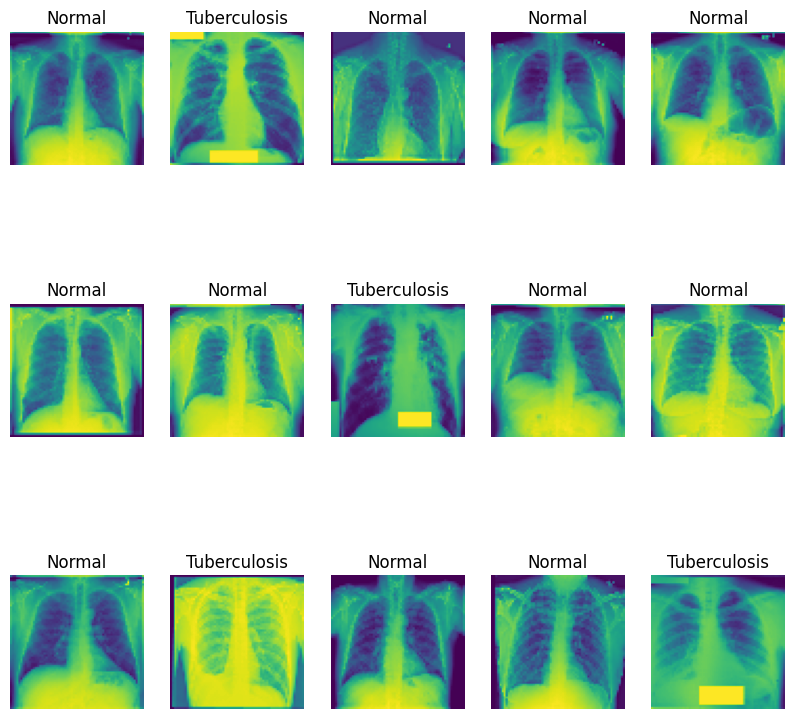

In [2]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    print(images[i].shape)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.CenterCrop(100, 100)
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
# Calculate class weights
class_counts = train_ds.reduce(
    initial_state=tf.zeros(2), 
    reduce_func=lambda state, batch: state + tf.cast(tf.math.reduce_sum(batch[1], axis=0), tf.float32)
)
total_samples = tf.reduce_sum(class_counts)
class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}


In [5]:
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

# model = Sequential()
# model.add(keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)))
# model.add(preprocessing)

# # model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

In [6]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    keras.layers.GlobalAveragePooling2D(),

    # keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 64, 64, 1)         0         |
|                                                               |
| rescaling (Rescaling)     (None, 64, 64, 1)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                      

In [7]:
# train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
# earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
    # class_weight=class_weights,
)

Epoch 1/100
95/95 [==============================] - 18s 136ms/step - loss: 0.4327 - binary_accuracy: 0.8304 - val_loss: 0.4018 - val_binary_accuracy: 0.8135
Epoch 2/100
95/95 [==============================] - 10s 103ms/step - loss: 0.3213 - binary_accuracy: 0.8548 - val_loss: 0.3749 - val_binary_accuracy: 0.8228
Epoch 3/100
95/95 [==============================] - 10s 104ms/step - loss: 0.2671 - binary_accuracy: 0.8783 - val_loss: 0.2641 - val_binary_accuracy: 0.8743
Epoch 4/100
95/95 [==============================] - 10s 104ms/step - loss: 0.2189 - binary_accuracy: 0.9038 - val_loss: 0.2638 - val_binary_accuracy: 0.8929
Epoch 5/100
95/95 [==============================] - 10s 104ms/step - loss: 0.1740 - binary_accuracy: 0.9246 - val_loss: 0.1786 - val_binary_accuracy: 0.9352
Epoch 6/100
95/95 [==============================] - 6s 59ms/step - loss: 0.1504 - binary_accuracy: 0.9428 - val_loss: 0.1547 - val_binary_accuracy: 0.9444
Epoch 7/100
95/95 [==============================] - 9

Epochs run: 45


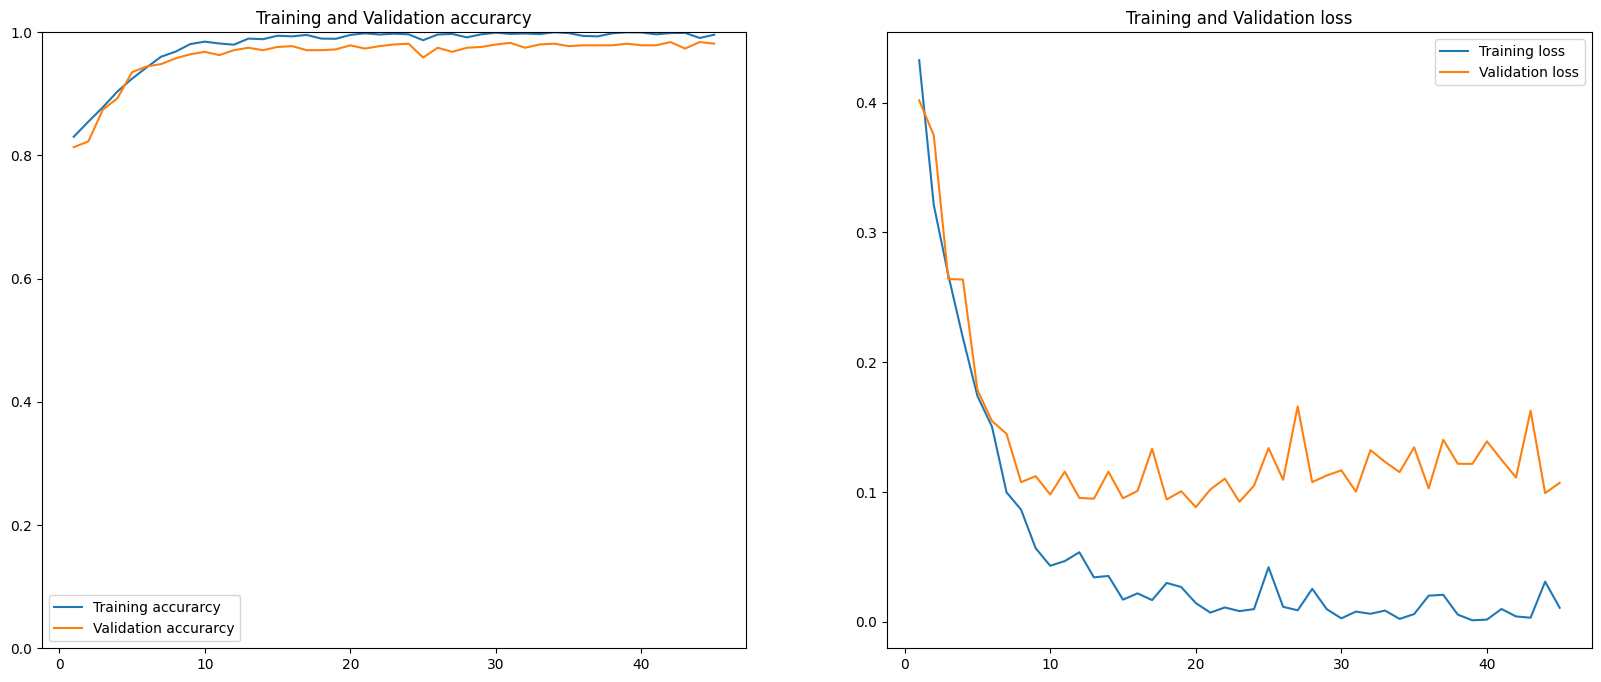

In [8]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [9]:
import tensorflow as tf

test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,
                                                   color_mode=COLOR_MODE,
                                                   batch_size=32,
                                                   image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                )


preprocessing = tf.keras.Sequential([
    # tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.CenterCrop(100, 100)
])

# Preprocess the test dataset
test_ds_preprocessed = test_ds.map(lambda x, y: (preprocessing(x), y))


y_pred = model.evaluate(test_ds, verbose=0)
prediction = model.predict(test_ds)

print("Test accuracy:", y_pred[1]*100)
print("Test loss:", y_pred[0]*100)

Found 420 files belonging to 2 classes.
14/14 [==============================] - 1s 22ms/step
Test accuracy: 97.3809540271759
Test loss: 7.178950309753418


Found 420 files belonging to 2 classes.
1/1 [==============================] - 0s 84ms/step
[[606   9]
 [  7 134]]


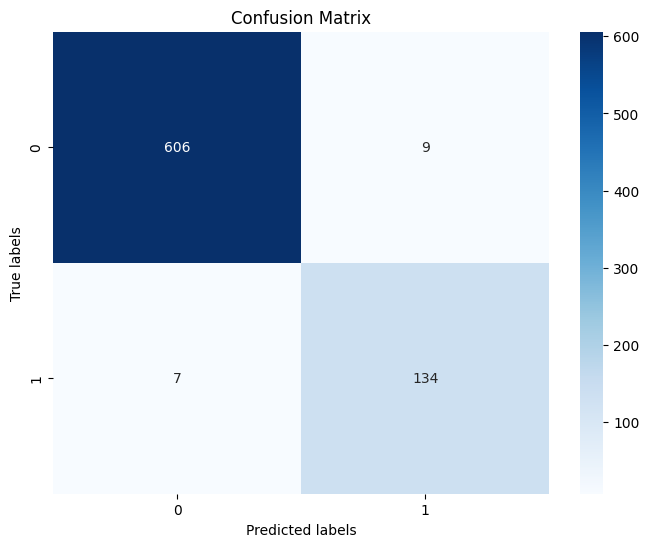

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TESTING_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    color_mode=COLOR_MODE,
    shuffle=True,
)

validation_dataset = val_ds

# Get true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Iterate over the validation dataset
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_probabilities.extend(predictions)

# Convert probabilities to predicted labels
predicted_labels = np.where(np.array(predicted_probabilities) > 0.5, 1, 0)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# SAVING THE MODEL

# save the iris classification model
model.save("tb-cnn.h5")

In [12]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model("tb-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


14/14 [==============================] - 1s 30ms/step - loss: 0.0718 - binary_accuracy: 0.9738


In [13]:
from sklearn.metrics import classification_report


print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       615
Tuberculosis       0.94      0.95      0.94       141

    accuracy                           0.98       756
   macro avg       0.96      0.97      0.97       756
weighted avg       0.98      0.98      0.98       756

